In [22]:
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

N = 100 #number of neurons
seuil = 60 #the threshold of activation of neuron, in mV, global variable, used in functions
Vmax = 120
Vmin=-10
nb_steps = 100 #number of simulation
beta=0.55 #beta*Vmax

In [2]:
def init_syst_links():
    """Create a matrix of 2 dimensions which shows the connections between neurons in the system.
    Initiated randomly and stay the same always. (a transpose matrix of the regular matrix)
    syst_links[i][j] = 1: j connects and can send signal to i, not in reverse
    syst_links[i][j] = 0: j doesnt connect to i
    syst_links[i][i] = k: the decrease factor of potential of the neuron i"""
    syst_links = np.random.rand(N,N)
    for i in range(N):
        for j in range(N):
            if i != j:
                syst_links[i][j] = random.choice([0.0, 1.0])*(-1)**random.randint(0,1)
            else:
                syst_links[i][j] = random.uniform(0.9,0.95)
    syst_links.transpose()
    return syst_links

In [3]:
def init_syst_potentiel():
    """Create a matrix of 2D which shows the potential of each neuron at time t of the simulation.
    Initiated randomly.
    syst_potentiel[i][j] = 0 for every i != j;
    syst_potentiel[i][i] = value of potential of neuron i"""

    syst_potentiel = np.zeros((N,N))
    return syst_potentiel

In [4]:
def init_syst_state():
    """Create a matrix of size(nb_neuron,1) which shows the state of activation of a neuron.
    Initiated randomly.
    syst_act[i][0] = 0: neuron i isnt activated, it cant send signal to others
    syst_act[i][0] = 1: neuron i is activated and can send signal to others
    When the potential of a neuron i passes the threshold, syst_act[i][0] = 1 at the next step
    After release all its potential, syst_act[i][0] = 0 at the next step"""

    syst_state = np.ones((N,1))
    return syst_state

In [5]:
def matrix_Ni(i,coeff_Tt):
    """Create a matrix 2D which helps keeping the potential of each neuron of the previous step to the next step
    Size: (nb_neuron,1)
    Only the i of the neuron in current execution is set to 1. All the others elements are 0."""

    matrix_Ni = np.zeros((N,1))
    if(coeff_Tt==0):
        matrix_Ni[i][0] = 1   
    else :
        matrix_Ni[i][0] = -1
    return matrix_Ni

In [6]:
def func_act(val_poten):
    """float => float
    If the potential of a neuron is superior than the threshold, it's activated.
    When a neuron is activated, its potential increase immediately to Vmax"""
    if val_poten < Vmin:
        return 0
    elif val_poten < seuil:
        return val_poten
    else :
        return beta*Vmax

In [7]:
def start_syst(syst_potentiel, syst_state):
    """Send in the information in form electric ranged between 0 and Vmax (mV)
     to kick off the system.
     Return a matrix of the potentials of the system and a matrix of the neurons' states"""

    kicked_off = syst_potentiel
    state_chaged = syst_state
    for i in range(N):
        kicked_off[i][i] = func_act(syst_potentiel[i][i] + random.uniform(0, Vmax))
        if kicked_off[i][i] >= seuil:
            state_chaged[i][0] = 1
        else:
            state_chaged[i][0] = 0
    return (kicked_off, state_chaged)

In [8]:
def update_system(syst_potentiel, syst_links, syst_state):
    """matrix(N,N) * matrix(N,N) * matrix(N,1) -> tuple(matrix(N,N), matrix(N,1))
    Calculate the potentials of all the neurons at the time t+1 and also update theirs state at time t+1 (activated or not)
    All neurons will be update simultaneously.
    Return the potentials and their states of the whole system in form matrix."""
    new_syst_potentiel = copy.deepcopy(syst_potentiel)
    new_syst_state = copy.deepcopy(syst_state)
    var = 0 #variable temporary
    for i in range(N):
        #print((-1) ** syst_state[i][0])
        var = np.dot(syst_links[i], np.dot(syst_potentiel, syst_state + matrix_Ni(i,syst_state[i][0])))[0]
        var = func_act(var)
        if var == beta*Vmax:
            new_syst_state[i][0] = 1
        else:
            new_syst_state[i][0] = 0
        
        new_syst_potentiel[i][i] = var

    return (new_syst_potentiel, new_syst_state)

In [9]:
def non_transmittable(syst_state):
    """Verify if there is no neuron that can transmit signal to others
    return a bool"""
    res = True
    for i in range(N):
        if syst_state[i][0] == 1:
            res = False
            break
    return res

In [10]:
def simulation(syst_potentiel, syst_links, syst_state, nb_steps):
    """Return a list of all the matrixes, each matrix shows the potentials of the system
    at moment t"""
    #res: list[matrix(N,N)]
    #res_graph[matrix(N,N)] pour l'affichage graphique des états de la matrice Tt
    res_potentials = []
    res_states=[]
    
    new_p = syst_potentiel
    res_potentials.append(copy.deepcopy(new_p))
    new_s = syst_state
    res_states.append(copy.deepcopy(new_s))
    
    for i in range(nb_steps):
        new_p, new_s = update_system(new_p, syst_links, new_s)
        #if non_transmittable(new_s):
           # new_p, new_s = start_syst(new_p, new_s)
        #else:
            #new_p, new_s = update_system(new_p, syst_links, new_s)
            
        res_potentials.append(copy.deepcopy(new_p))
        res_states.append(copy.deepcopy(new_s))
    
    return res_potentials,res_states

In [11]:
####Start the program

Vt = init_syst_potentiel()
C = init_syst_links()
Tt = init_syst_state()
Vt, Tt = start_syst(Vt, Tt)

In [12]:
res_potentials,res_states=simulation(Vt,C,Tt,nb_steps)

In [17]:
def trace_state(resultat_states,color,fig_size=(10,10),markersize=2,v_space=0):
    '''return a figure of the evolution of the state of each neuron in the network throught time
        resultat_states : a list that contains the states of neurons
        color : color of the plot
        fig_size : tuple that contain size of the plot 
        markersize : size of the marker in the plot
        v_space : the vertical space (on the vertical axis) between neuron'''
    
    fig=plt.figure(figsize=fig_size)

    for j in range(len(resultat_states)):
        for i  in range(len(resultat_states[j])):
            if(resultat_states[j][i][0]==1):
                plt.plot(j,i+v_space,marker='o',color=color,markersize=markersize)
    return fig

In [14]:
def trace_potential(resultat_potentials,resultat_states,color,fig_size=(10,10),linewidth=1):
    '''return a figure of the evolution of the potential of the network throught time
        resultat_potentials : a list that contains the potentials of neurons
        resultat_states : a list that contains the sate of neurons
        color : color of the plot
        fig_size : tuple that contain size of the plot 
        linewidth : size of line in the plot'''
    
    fig=plt.figure(figsize=fig_size)
    
    Lx=[]
    Ly=[]

    for j in range(len(resultat_potentials)):
        S=0 #Sum of the potentiel at a specific time, in fact the time j*delta_t
        Lx.append(j)
        for i  in range(len(resultat_potentials[j])):
            if(resultat_states[j][i][0]==1):
                S=S+resultat_potentials[j][i][i] #the potential of the neuron i is on the diagonal (matrix index (i,i)) of the matrix res_graphique[j]
        
        Ly.append(S)
        
    plt.plot(Lx,Ly,color=color, linewidth=linewidth)
        
    return fig

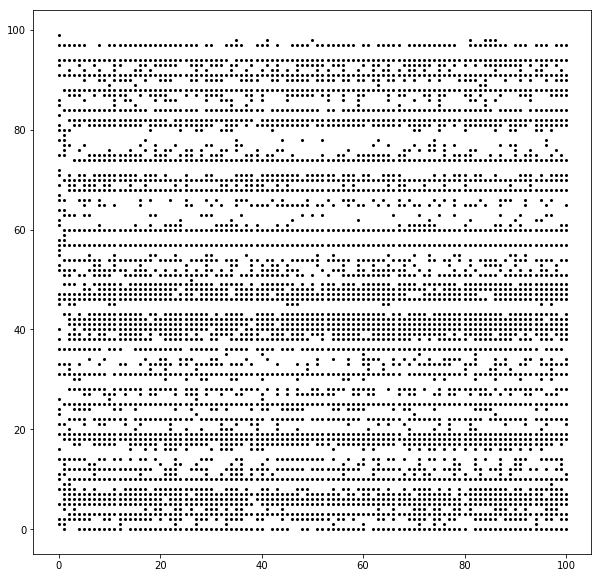

In [16]:
fig=trace_state(res_states,'black',fig_size=(10,10),markersize=2,v_space=0)
fig.savefig("test.pdf")
fig #show the figure

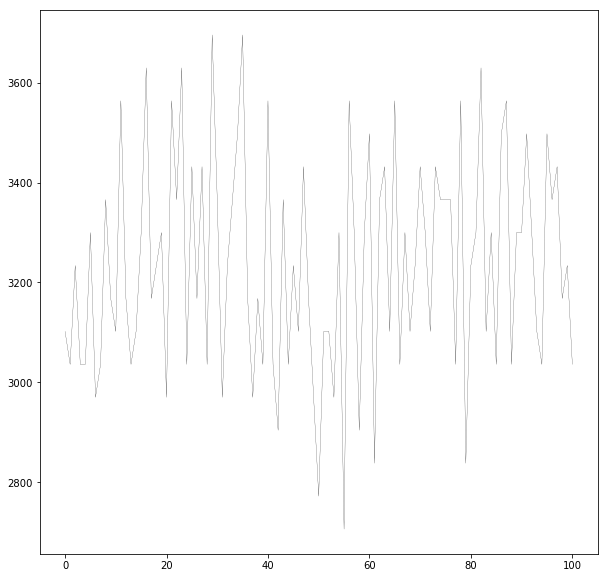

In [18]:
fig=trace_potential(res_potentials,res_states,'black',fig_size=(10,10),linewidth=0.2)
fig.savefig("test.pdf")
fig #show the figure